# 🏸 Badminton Shot Prediction System
## Real-time Classification using ESP32 IMU Data

This notebook creates a machine learning model to predict badminton shots using accelerometer and gyroscope data from ESP32 with ICM-20948 sensor.

**Shot Types to Classify:**
- 🏸 **Smash**: High power overhead shot
- 🎯 **Drop**: Soft placement shot
- 🚀 **Drive**: Fast horizontal shot
- ⬆️ **Lift**: Defensive high shot
- 🔄 **Clear**: Deep court shot

In [20]:
# 📦 Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import joblib
import warnings
warnings.filterwarnings('ignore')

print("🏸 BADMINTON SHOT PREDICTION SYSTEM")
print("=" * 50)
print("📊 Loading libraries for ML-based shot classification")
print("🎯 Target: Classify Smash, Drop, Drive, Lift, Clear shots")
print("📡 Data Source: ESP32 ICM-20948 IMU sensor")

🏸 BADMINTON SHOT PREDICTION SYSTEM
📊 Loading libraries for ML-based shot classification
🎯 Target: Classify Smash, Drop, Drive, Lift, Clear shots
📡 Data Source: ESP32 ICM-20948 IMU sensor


In [21]:
# 📁 Load Dataset
print("📁 LOADING BADMINTON SHOT DATASET")
print("-" * 40)

try:
    # Load the main dataset
    data_path = r"C:\Users\dipes\Desktop\test1.xlsx"
    df = pd.read_excel(data_path)
    
    print(f"✅ Dataset loaded successfully!")
    print(f"📊 Dataset shape: {df.shape}")
    print(f"📋 Columns: {list(df.columns)}")
    
    # Display first few rows
    print(f"\n🔍 First 5 rows:")
    print(df.head())
    
    # Check for missing values
    print(f"\n❓ Missing values:")
    missing_count = df.isnull().sum()
    print(missing_count[missing_count > 0])
    
    if missing_count.sum() == 0:
        print("✅ No missing values found!")
    
except FileNotFoundError:
    print(f"❌ Dataset not found at {data_path}")
    print("🔧 Creating synthetic badminton shot data for demonstration...")
    
    # Create synthetic dataset based on ESP32 data structure
    np.random.seed(42)
    n_samples = 1000
    
    # Generate realistic badminton shot data
    shot_types = ['Smash', 'Drop', 'Drive', 'Lift', 'Clear']
    shots = np.random.choice(shot_types, n_samples)
    
    # Create features based on your ESP32 data format
    data = []
    for shot in shots:
        if shot == 'Smash':
            max_acc = np.random.normal(1200, 200)  # High acceleration
            max_gyro = np.random.normal(350, 50)   # High rotation
            swing_speed = max_acc * 0.005 + np.random.normal(0, 0.5)
        elif shot == 'Drop':
            max_acc = np.random.normal(250, 50)    # Low acceleration
            max_gyro = np.random.normal(100, 30)   # Low rotation
            swing_speed = max_acc * 0.005 + np.random.normal(0, 0.2)
        elif shot == 'Drive':
            max_acc = np.random.normal(600, 100)   # Medium-high acceleration
            max_gyro = np.random.normal(180, 40)   # Medium rotation
            swing_speed = max_acc * 0.005 + np.random.normal(0, 0.3)
        elif shot == 'Lift':
            max_acc = np.random.normal(400, 80)    # Medium acceleration
            max_gyro = np.random.normal(220, 50)   # Medium-high rotation
            swing_speed = max_acc * 0.005 + np.random.normal(0, 0.4)
        else:  # Clear
            max_acc = np.random.normal(800, 150)   # High acceleration
            max_gyro = np.random.normal(280, 60)   # High rotation
            swing_speed = max_acc * 0.005 + np.random.normal(0, 0.4)
        
        data.append({
            'shot_type': shot,
            'max_acc': max(0, max_acc),
            'max_gyroY': max(0, max_gyro),
            'swing_speed_est': max(0, swing_speed),
            'timestamp': pd.Timestamp.now() + pd.Timedelta(seconds=np.random.randint(0, 86400))
        })
    
    df = pd.DataFrame(data)
    print(f"📊 Synthetic dataset created: {df.shape}")
    print(f"🎯 Shot distribution:")
    print(df['shot_type'].value_counts())

print(f"\n✅ Dataset ready for analysis!")

📁 LOADING BADMINTON SHOT DATASET
----------------------------------------
✅ Dataset loaded successfully!
📊 Dataset shape: (1516, 9)
📋 Columns: ['ACC', 'Unnamed: 1', 'Unnamed: 2', 'GYR', 'Unnamed: 4', 'Unnamed: 5', 'MAG', 'Unnamed: 7', 'Unnamed: 8']

🔍 First 5 rows:
    ACC Unnamed: 1 Unnamed: 2  GYR Unnamed: 4 Unnamed: 5   MAG Unnamed: 7  \
0     X          Y          Z    X          Y          Z     X          Y   
1 -12.6      -21.6     -704.2    1       -3.2        2.3  33.2       63.3   
2 -10.8      -40.2     -975.6  0.1        3.4       -0.8  32.2         62   
3 -12.5      -43.7     -980.1  0.6        2.5        2.8  33.2       61.8   
4  -4.8        -43     -975.9  1.2        0.2        1.5  33.9       62.2   

  Unnamed: 8  
0          Z  
1       68.6  
2       70.2  
3       69.3  
4       70.8  

❓ Missing values:
Series([], dtype: int64)
✅ No missing values found!

✅ Dataset ready for analysis!


In [22]:
# # 🏷️ AUTO-LABELING BASED ON ESP32 CLASSIFICATION RULES
# print("\n🏷️ AUTO-LABELING SYSTEM")
# print("=" * 30)

# def auto_label_shots(df):
#     """Apply ESP32 classification rules to automatically label shots"""
#     print("🔍 Analyzing column names for acceleration and gyroscope data...")
    
#     # Find acceleration columns (ACC, max_acc, acceleration, etc.)
#     acc_col = None
#     gyro_col = None
    
#     for col in df.columns:
#         col_lower = col.lower()
#         if 'acc' in col_lower and acc_col is None:
#             acc_col = col
#             print(f"   📈 Found acceleration column: {col}")
#         elif 'gyr' in col_lower and gyro_col is None:
#             gyro_col = col
#             print(f"   🔄 Found gyroscope column: {col}")
    
#     if acc_col is None or gyro_col is None:
#         print("❌ Could not find required acceleration and gyroscope columns")
#         print(f"Available columns: {list(df.columns)}")
#         return df
    
#     print(f"\\n🤖 Applying ESP32 classification rules...")
#     print(f"   Using: {acc_col} (acceleration) and {gyro_col} (gyroscope)")
    
#     shot_types = []
    
#     for _, row in df.iterrows():
#         max_acc = abs(float(row[acc_col]))  # Ensure positive values
#         max_gyro = abs(float(row[gyro_col]))  # Ensure positive values
        
#         # Your ESP32 classification logic
#         if max_acc > 1000 and max_gyro > 300:
#             shot_types.append("Smash")
#         elif max_acc > 500 and max_gyro < 200:
#             shot_types.append("Drive")
#         elif max_acc < 300:
#             shot_types.append("Drop")
#         else:
#             shot_types.append("Lift")
    
#     df['shot_type'] = shot_types
    
#     # Display classification results
#     print(f"\\n✅ Auto-labeling completed!")
#     print(f"📊 Shot distribution:")
#     distribution = df['shot_type'].value_counts()
#     for shot, count in distribution.items():
#         percentage = (count / len(df)) * 100
#         print(f"   🏸 {shot}: {count} shots ({percentage:.1f}%)")
    
#     # Show classification boundaries used
#     print(f"\\n📋 Classification Rules Applied:")
#     print(f"   🔥 Smash: ACC > 1000 AND GYR > 300")
#     print(f"   🚀 Drive: ACC > 500 AND GYR < 200") 
#     print(f"   🎯 Drop: ACC < 300")
#     print(f"   ⬆️ Lift: All other combinations")
    
#     return df

# # Apply auto-labeling if shot_type column is missing
# if 'shot_type' not in df.columns:
#     print("🏷️ No shot_type column found. Applying auto-labeling...")
#     df = auto_label_shots(df)
# else:
#     print("✅ shot_type column already exists in dataset")
#     print(f"📊 Existing distribution: {df['shot_type'].value_counts().to_dict()}")

# print(f"\\n✅ Dataset preparation completed!")
# print(f"📊 Final dataset shape: {df.shape}")
# print(f"📋 Columns: {list(df.columns)}")

# Replace the auto_label_shots function with this improved version

# 🏷️ IMPROVED AUTO-LABELING WITH ERROR HANDLING
def auto_label_shots(df):
    """Apply your existing classification rules to label the data with robust error handling"""
    
    # Find acceleration and gyroscope columns
    acc_columns = [col for col in df.columns if 'acc' in col.lower()]
    gyro_columns = [col for col in df.columns if 'gyr' in col.lower()]
    
    if not acc_columns:
        print("❌ No acceleration columns found!")
        print(f"Available columns: {list(df.columns)}")
        return df
    
    if not gyro_columns:
        print("❌ No gyroscope columns found!")
        print(f"Available columns: {list(df.columns)}")
        return df
    
    acc_col = acc_columns[0]
    gyro_col = gyro_columns[0]
    
    print(f"📊 Using columns: {acc_col} (acceleration), {gyro_col} (gyroscope)")
    
    # Clean and convert data
    shot_types = []
    valid_rows = 0
    invalid_rows = 0
    
    for index, row in df.iterrows():
        try:
            # Handle different data formats
            acc_value = row[acc_col]
            gyro_value = row[gyro_col]
            
            # Convert to string first, then clean
            acc_str = str(acc_value).strip()
            gyro_str = str(gyro_value).strip()
            
            # Skip empty, NaN, or invalid values
            if acc_str.lower() in ['nan', 'none', '', 'x', 'null'] or gyro_str.lower() in ['nan', 'none', '', 'x', 'null']:
                shot_types.append("Unknown")
                invalid_rows += 1
                continue
            
            # Try to convert to float
            max_acc = abs(float(acc_str))
            max_gyro = abs(float(gyro_str))
            
            # Your ESP32 classification logic
            if max_acc > 1000 and max_gyro > 300:
                shot_type = "Smash"
            elif max_acc > 500 and max_gyro < 200:
                shot_type = "Drive"
            elif max_acc < 300:
                shot_type = "Drop"
            else:
                shot_type = "Lift"
            
            shot_types.append(shot_type)
            valid_rows += 1
            
        except (ValueError, TypeError) as e:
            # Handle conversion errors
            shot_types.append("Unknown")
            invalid_rows += 1
            if invalid_rows <= 5:  # Show first 5 errors only
                print(f"⚠️ Row {index}: Cannot convert '{row[acc_col]}', '{row[gyro_col]}' to numbers")
    
    # Add shot_type column
    df['shot_type'] = shot_types
    
    # Report results
    print(f"\n📈 Processing Results:")
    print(f"✅ Valid rows processed: {valid_rows}")
    print(f"❌ Invalid rows (marked as Unknown): {invalid_rows}")
    
    # Show distribution excluding Unknown
    valid_shots = df[df['shot_type'] != 'Unknown']['shot_type'].value_counts()
    if len(valid_shots) > 0:
        print(f"\n🏸 Shot Distribution (valid data):")
        for shot, count in valid_shots.items():
            percentage = (count / valid_rows) * 100 if valid_rows > 0 else 0
            print(f"   {shot}: {count} shots ({percentage:.1f}%)")
    
    # Clean up Unknown rows if user wants
    unknown_count = (df['shot_type'] == 'Unknown').sum()
    if unknown_count > 0:
        print(f"\n🧹 Found {unknown_count} rows with invalid data.")
        print("   These will be removed from training to improve model accuracy.")
        df_clean = df[df['shot_type'] != 'Unknown'].copy()
        print(f"   Dataset size: {len(df)} → {len(df_clean)} rows")
        return df_clean
    
    return df

# 🔍 DATA INSPECTION
print("🔍 Inspecting your dataset structure...")
print(f"📊 Dataset shape: {df.shape}")
print(f"📋 Columns: {list(df.columns)}")

# Show first few rows of each column to identify issues
print("\n🔬 Sample data inspection:")
for col in df.columns:
    sample_values = df[col].head(3).tolist()
    print(f"   {col}: {sample_values}")

# Apply auto-labeling if shot_type column is missing
if 'shot_type' not in df.columns:
    print("\n🏷️ No shot_type column found. Applying auto-labeling...")
    df = auto_label_shots(df)
    
    # Verify we have enough data for training
    if len(df) < 10:
        print("❌ Insufficient valid data for training!")
        print("🔧 Creating synthetic data for demonstration...")
        df = create_synthetic_badminton_data()
    else:
        print("✅ Auto-labeling completed successfully!")
else:
    print("✅ shot_type column already exists in dataset")

print(f"\n📊 Final dataset shape: {df.shape}")
if 'shot_type' in df.columns:
    print(f"🎯 Shot type distribution:")
    for shot, count in df['shot_type'].value_counts().items():
        print(f"   {shot}: {count} samples")

🔍 Inspecting your dataset structure...
📊 Dataset shape: (1516, 9)
📋 Columns: ['ACC', 'Unnamed: 1', 'Unnamed: 2', 'GYR', 'Unnamed: 4', 'Unnamed: 5', 'MAG', 'Unnamed: 7', 'Unnamed: 8']

🔬 Sample data inspection:
   ACC: ['X', -12.6, -10.8]
   Unnamed: 1: ['Y', -21.6, -40.2]
   Unnamed: 2: ['Z', -704.2, -975.6]
   GYR: ['X', 1, 0.1]
   Unnamed: 4: ['Y', -3.2, 3.4]
   Unnamed: 5: ['Z', 2.3, -0.8]
   MAG: ['X', 33.2, 32.2]
   Unnamed: 7: ['Y', 63.3, 62]
   Unnamed: 8: ['Z', 68.6, 70.2]

🏷️ No shot_type column found. Applying auto-labeling...
📊 Using columns: ACC (acceleration), GYR (gyroscope)

📈 Processing Results:
✅ Valid rows processed: 1515
❌ Invalid rows (marked as Unknown): 1

🏸 Shot Distribution (valid data):
   Drop: 970 shots (64.0%)
   Lift: 307 shots (20.3%)
   Drive: 238 shots (15.7%)

🧹 Found 1 rows with invalid data.
   These will be removed from training to improve model accuracy.
   Dataset size: 1516 → 1515 rows
✅ Auto-labeling completed successfully!

📊 Final dataset shape

In [23]:
# # 📊 Exploratory Data Analysis
# print("📊 EXPLORATORY DATA ANALYSIS")
# print("=" * 40)

# # Basic statistics
# print("📈 Dataset Statistics:")
# print(df.describe())

# # Shot type distribution
# if 'shot_type' in df.columns:
#     print(f"\n🎯 Shot Type Distribution:")
#     shot_counts = df['shot_type'].value_counts()
#     print(shot_counts)
    
#     # Create visualizations
#     fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
#     # Shot distribution pie chart
#     axes[0, 0].pie(shot_counts.values, labels=shot_counts.index, autopct='%1.1f%%', startangle=90)
#     axes[0, 0].set_title('🎯 Shot Type Distribution')
    
#     # Feature distributions by shot type
#     numeric_cols = df.select_dtypes(include=[np.number]).columns
#     if len(numeric_cols) >= 2:
#         feature1 = numeric_cols[0]
#         feature2 = numeric_cols[1] if len(numeric_cols) > 1 else numeric_cols[0]
        
#         # Box plots for first feature
#         df.boxplot(column=feature1, by='shot_type', ax=axes[0, 1])
#         axes[0, 1].set_title(f'📊 {feature1} by Shot Type')
#         axes[0, 1].set_xlabel('Shot Type')
        
#         # Box plots for second feature
#         df.boxplot(column=feature2, by='shot_type', ax=axes[1, 0])
#         axes[1, 0].set_title(f'📊 {feature2} by Shot Type')
#         axes[1, 0].set_xlabel('Shot Type')
        
#         # Scatter plot
#         for shot in df['shot_type'].unique():
#             shot_data = df[df['shot_type'] == shot]
#             axes[1, 1].scatter(shot_data[feature1], shot_data[feature2], 
#                              label=shot, alpha=0.6, s=50)
#         axes[1, 1].set_xlabel(feature1)
#         axes[1, 1].set_ylabel(feature2)
#         axes[1, 1].set_title(f'🔍 {feature1} vs {feature2}')
#         axes[1, 1].legend()
    
#     plt.tight_layout()
#     plt.show()
    
#     # Correlation analysis
#     numeric_df = df.select_dtypes(include=[np.number])
#     if not numeric_df.empty:
#         plt.figure(figsize=(10, 8))
#         correlation_matrix = numeric_df.corr()
#         sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
#                    square=True, fmt='.2f')
#         plt.title('🔗 Feature Correlation Matrix')
#         plt.tight_layout()
#         plt.show()

# else:
#     print("⚠️ No shot_type column found. Please check your dataset structure.")
#     print("Available columns:", list(df.columns))

# Replace the problematic section with this diagnostic and flexible code

# 🔍 DATASET STRUCTURE ANALYSIS
print("🔍 Analyzing your dataset structure...")
print(f"📊 Dataset shape: {df.shape}")
print(f"📋 Available columns: {list(df.columns)}")
print(f"📋 Column data types: {df.dtypes}")

# Show sample data to understand the structure
print("\n🔬 Sample data (first 3 rows):")
print(df.head(3))

# Show unique values for each column to understand the data format
print("\n📊 Data analysis per column:")
for col in df.columns:
    print(f"\n   📋 {col}:")
    print(f"      Data type: {df[col].dtype}")
    print(f"      Non-null count: {df[col].count()}/{len(df)}")
    print(f"      Sample values: {df[col].head(3).tolist()}")
    if df[col].dtype == 'object':
        unique_vals = df[col].dropna().unique()[:10]  # Show first 10 unique values
        print(f"      Unique values: {unique_vals}")

# 🛠️ FLEXIBLE COLUMN DETECTION
def detect_sensor_columns(df):
    """Intelligently detect acceleration and gyroscope columns"""
    
    acc_patterns = ['acc', 'acceleration', 'accel', 'max_acc']
    gyro_patterns = ['gyr', 'gyro', 'gyroscope', 'max_gyro', 'max_gyroY']
    speed_patterns = ['speed', 'velocity', 'swing_speed', 'swing_speed_est']
    
    acc_cols = []
    gyro_cols = []
    speed_cols = []
    
    # Search for matching columns
    for col in df.columns:
        col_lower = col.lower()
        
        # Check for acceleration columns
        for pattern in acc_patterns:
            if pattern.lower() in col_lower:
                acc_cols.append(col)
                break
        
        # Check for gyroscope columns
        for pattern in gyro_patterns:
            if pattern.lower() in col_lower:
                gyro_cols.append(col)
                break
                
        # Check for speed columns
        for pattern in speed_patterns:
            if pattern.lower() in col_lower:
                speed_cols.append(col)
                break
    
    print(f"\n🎯 Column Detection Results:")
    print(f"   🔍 Acceleration columns found: {acc_cols}")
    print(f"   🔍 Gyroscope columns found: {gyro_cols}")
    print(f"   🔍 Speed columns found: {speed_cols}")
    
    return acc_cols, gyro_cols, speed_cols

# Detect available sensor columns
acc_columns, gyro_columns, speed_columns = detect_sensor_columns(df)

# 🔧 FLEXIBLE DATA PROCESSING
def process_flexible_data(df, acc_cols, gyro_cols, speed_cols):
    """Process data regardless of column names"""
    
    # Create a working copy
    df_processed = df.copy()
    
    # Extract acceleration data
    if acc_cols:
        acc_col = acc_cols[0]  # Use first available acceleration column
        print(f"✅ Using acceleration column: {acc_col}")
        
        # Clean and convert acceleration data
        df_processed['clean_acc'] = pd.to_numeric(df_processed[acc_col], errors='coerce')
        df_processed['clean_acc'] = df_processed['clean_acc'].fillna(0).abs()
    else:
        print("❌ No acceleration column found - creating synthetic data")
        df_processed['clean_acc'] = np.random.normal(500, 200, len(df_processed))
    
    # Extract gyroscope data
    if gyro_cols:
        gyro_col = gyro_cols[0]  # Use first available gyroscope column
        print(f"✅ Using gyroscope column: {gyro_col}")
        
        # Clean and convert gyroscope data
        df_processed['clean_gyro'] = pd.to_numeric(df_processed[gyro_col], errors='coerce')
        df_processed['clean_gyro'] = df_processed['clean_gyro'].fillna(0).abs()
    else:
        print("❌ No gyroscope column found - creating synthetic data")
        df_processed['clean_gyro'] = np.random.normal(200, 100, len(df_processed))
    
    # Extract speed data
    if speed_cols:
        speed_col = speed_cols[0]
        print(f"✅ Using speed column: {speed_col}")
        df_processed['clean_speed'] = pd.to_numeric(df_processed[speed_col], errors='coerce')
        df_processed['clean_speed'] = df_processed['clean_speed'].fillna(0).abs()
    else:
        print("ℹ️ No speed column found - calculating from acceleration")
        df_processed['clean_speed'] = df_processed['clean_acc'] * 0.005
    
    # Remove rows with invalid data
    valid_mask = (df_processed['clean_acc'] > 0) & (df_processed['clean_gyro'] > 0)
    df_clean = df_processed[valid_mask].copy()
    
    print(f"\n🧹 Data cleaning results:")
    print(f"   Original rows: {len(df_processed)}")
    print(f"   Valid rows: {len(df_clean)}")
    print(f"   Removed: {len(df_processed) - len(df_clean)} invalid rows")
    
    return df_clean

# Process the data with flexible column detection
df_clean = process_flexible_data(df, acc_columns, gyro_columns, speed_columns)

# 🏷️ FLEXIBLE SHOT CLASSIFICATION
def classify_shots_flexible(df):
    """Classify shots using cleaned data columns"""
    
    shot_types = []
    
    for _, row in df.iterrows():
        max_acc = row['clean_acc']
        max_gyro = row['clean_gyro']
        
        # Create metrics for classification
        power_ratio = max_acc / (max_gyro + 1)
        total_power = max_acc + max_gyro
        
        # Classification logic using cleaned data
        if max_acc > 1000 and max_gyro > 280:
            shot_type = "Smash"
        elif max_acc > 800 and max_gyro > 200 and power_ratio < 4:
            shot_type = "Clear"
        elif max_acc > 500 and max_gyro < 200 and power_ratio > 3:
            shot_type = "Drive"
        elif max_acc < 300 and max_gyro < 150:
            shot_type = "Drop"
        elif max_gyro > max_acc * 0.4:
            shot_type = "Lift"
        else:
            # Fallback based on total power
            if total_power > 1200:
                shot_type = "Smash"
            elif total_power > 700:
                shot_type = "Clear"
            elif total_power > 400:
                shot_type = "Drive"
            else:
                shot_type = "Drop"
        
        shot_types.append(shot_type)
    
    return shot_types

# Apply shot classification if we have enough data
if len(df_clean) >= 10:
    print("\n🏷️ Applying flexible shot classification...")
    df_clean['shot_type'] = classify_shots_flexible(df_clean)
    
    print(f"✅ Classification completed!")
    print(f"🏸 Shot distribution:")
    for shot, count in df_clean['shot_type'].value_counts().items():
        percentage = (count / len(df_clean)) * 100
        print(f"   {shot}: {count} ({percentage:.1f}%)")
    
    # Rename cleaned columns to standard names for feature engineering
    df_clean = df_clean.rename(columns={
        'clean_acc': 'max_acc',
        'clean_gyro': 'max_gyro',
        'clean_speed': 'swing_speed_est'
    })
    
    df = df_clean
    
else:
    print("\n📊 Insufficient valid data - creating balanced synthetic dataset...")
    # Create synthetic data if real data is insufficient
    np.random.seed(42)
    n_samples = 1000
    samples_per_class = n_samples // 5
    
    synthetic_data = []
    
    # Generate balanced synthetic badminton data
    shot_configs = {
        'Smash': {'acc_mean': 1200, 'acc_std': 200, 'gyro_mean': 320, 'gyro_std': 50},
        'Clear': {'acc_mean': 900, 'acc_std': 150, 'gyro_mean': 250, 'gyro_std': 40},
        'Drive': {'acc_mean': 600, 'acc_std': 100, 'gyro_mean': 160, 'gyro_std': 30},
        'Lift': {'acc_mean': 450, 'acc_std': 80, 'gyro_mean': 280, 'gyro_std': 50},
        'Drop': {'acc_mean': 200, 'acc_std': 50, 'gyro_mean': 80, 'gyro_std': 20}
    }
    
    for shot_type, config in shot_configs.items():
        for _ in range(samples_per_class):
            acc = max(50, np.random.normal(config['acc_mean'], config['acc_std']))
            gyro = max(20, np.random.normal(config['gyro_mean'], config['gyro_std']))
            speed = acc * 0.005 + np.random.normal(0, 0.2)
            
            synthetic_data.append({
                'max_acc': acc,
                'max_gyro': gyro,
                'swing_speed_est': max(0.1, speed),
                'shot_type': shot_type
            })
    
    df = pd.DataFrame(synthetic_data)
    print(f"✅ Created synthetic dataset with {len(df)} samples")

print(f"\n🎯 Final dataset ready for training:")
print(f"📊 Shape: {df.shape}")
print(f"📋 Columns: {list(df.columns)}")
print(f"🏸 Shot types: {df['shot_type'].value_counts().to_dict()}")

🔍 Analyzing your dataset structure...
📊 Dataset shape: (1515, 10)
📋 Available columns: ['ACC', 'Unnamed: 1', 'Unnamed: 2', 'GYR', 'Unnamed: 4', 'Unnamed: 5', 'MAG', 'Unnamed: 7', 'Unnamed: 8', 'shot_type']
📋 Column data types: ACC           object
Unnamed: 1    object
Unnamed: 2    object
GYR           object
Unnamed: 4    object
Unnamed: 5    object
MAG           object
Unnamed: 7    object
Unnamed: 8    object
shot_type     object
dtype: object

🔬 Sample data (first 3 rows):
    ACC Unnamed: 1 Unnamed: 2  GYR Unnamed: 4 Unnamed: 5   MAG Unnamed: 7  \
1 -12.6      -21.6     -704.2    1       -3.2        2.3  33.2       63.3   
2 -10.8      -40.2     -975.6  0.1        3.4       -0.8  32.2         62   
3 -12.5      -43.7     -980.1  0.6        2.5        2.8  33.2       61.8   

  Unnamed: 8 shot_type  
1       68.6      Drop  
2       70.2      Drop  
3       69.3      Drop  

📊 Data analysis per column:

   📋 ACC:
      Data type: object
      Non-null count: 1515/1515
      Sample 

In [24]:
# # 🔧 Data Preprocessing & Feature Engineering
# print("🔧 DATA PREPROCESSING & FEATURE ENGINEERING")
# print("=" * 50)

# # Prepare features and target
# if 'shot_type' in df.columns:
#     # Separate features and target
#     target_col = 'shot_type'
#     feature_cols = [col for col in df.columns if col != target_col and col != 'timestamp']
    
#     print(f"🎯 Target variable: {target_col}")
#     print(f"📊 Feature columns ({len(feature_cols)}): {feature_cols}")
    
#     # Extract features and target
#     X = df[feature_cols].copy()
#     y = df[target_col].copy()
    
#     # Handle missing values
#     X = X.fillna(X.median())
    
#     # Feature Engineering - Create additional physics-based features
#     if 'max_acc' in X.columns and 'max_gyroY' in X.columns:
#         print("🧮 Creating physics-based features...")
        
#         # Power index (acceleration × gyroscope)
#         X['power_index'] = X['max_acc'] * X['max_gyroY'] / 1000
        
#         # Acceleration to gyro ratio
#         X['acc_gyro_ratio'] = X['max_acc'] / (X['max_gyroY'] + 1)
        
#         # Intensity factor
#         X['intensity'] = np.sqrt(X['max_acc']**2 + X['max_gyroY']**2)
        
#         # Shot aggressiveness
#         X['aggressiveness'] = (X['max_acc'] + X['max_gyroY']) / 2
        
#         print(f"✅ Added 4 engineered features")
#         print(f"📈 Total features: {X.shape[1]}")
    
#     # Feature scaling
#     print("\n📏 Scaling features...")
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)
#     X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
#     # Encode target labels
#     label_encoder = LabelEncoder()
#     y_encoded = label_encoder.fit_transform(y)
    
#     print(f"📋 Class mapping:")
#     for i, class_name in enumerate(label_encoder.classes_):
#         print(f"  {i}: {class_name}")
    
#     print(f"\n✅ Preprocessing completed!")
#     print(f"📊 Final dataset shape: {X_scaled.shape}")
#     print(f"🎯 Target classes: {len(label_encoder.classes_)}")
    
# else:
#     print("❌ Cannot proceed without shot_type column")
#     print("Please ensure your dataset contains the target variable.")

# Replace the feature engineering section with this improved version

# 🔧 ADVANCED FEATURE ENGINEERING FOR BADMINTON SHOTS
def create_advanced_features(df):
    """Create physics-based features specifically for badminton shot classification"""
    
    # Ensure we have the basic columns
    if 'max_acc' not in df.columns or ('max_gyroY' not in df.columns and 'max_gyro' not in df.columns):
        print("❌ Required columns missing for feature engineering")
        return df
    
    # Standardize column names
    if 'max_gyroY' in df.columns:
        df['max_gyro'] = df['max_gyroY']
    
    print("🔧 Creating advanced badminton-specific features...")
    
    # 1. POWER-BASED FEATURES
    df['power_index'] = df['max_acc'] * df['max_gyro'] / 1000
    df['explosive_power'] = (df['max_acc'] ** 1.5) * (df['max_gyro'] ** 0.5) / 1000
    
    # 2. RATIO FEATURES (Most Important!)
    df['acc_gyro_ratio'] = df['max_acc'] / (df['max_gyro'] + 1)  # Avoid division by zero
    df['gyro_acc_ratio'] = df['max_gyro'] / (df['max_acc'] + 1)
    
    # 3. INTENSITY FEATURES
    df['total_intensity'] = np.sqrt(df['max_acc']**2 + df['max_gyro']**2)
    df['weighted_intensity'] = (df['max_acc'] * 0.7) + (df['max_gyro'] * 0.3)
    
    # 4. SPEED-BASED FEATURES
    if 'swing_speed_est' in df.columns:
        df['speed_efficiency'] = df['swing_speed_est'] / (df['max_acc'] + 1) * 1000
        df['speed_power_ratio'] = df['swing_speed_est'] / (df['power_index'] + 1)
    else:
        df['swing_speed_est'] = df['max_acc'] * 0.005  # Estimate if missing
        df['speed_efficiency'] = df['swing_speed_est'] / (df['max_acc'] + 1) * 1000
        df['speed_power_ratio'] = df['swing_speed_est'] / (df['power_index'] + 1)
    
    # 5. BADMINTON-SPECIFIC THRESHOLDS
    df['is_high_power'] = (df['max_acc'] > 800).astype(int)
    df['is_high_rotation'] = (df['max_gyro'] > 250).astype(int)
    df['is_fast_shot'] = (df['swing_speed_est'] > 3.0).astype(int)
    
    # 6. INTERACTION FEATURES
    df['power_rotation_interaction'] = df['is_high_power'] * df['is_high_rotation']
    df['acc_squared'] = df['max_acc'] ** 2
    df['gyro_squared'] = df['max_gyro'] ** 2
    
    # 7. NORMALIZED FEATURES
    df['acc_normalized'] = df['max_acc'] / df['max_acc'].max()
    df['gyro_normalized'] = df['max_gyro'] / df['max_gyro'].max()
    
    print("✅ Advanced feature engineering completed!")
    print(f"📊 Total features created: {len(df.columns)} columns")
    
    return df

# 🎯 IMPROVED SHOT CLASSIFICATION RULES
def improved_auto_label_shots(df):
    """Improved classification rules based on badminton physics"""
    
    shot_types = []
    
    for _, row in df.iterrows():
        try:
            max_acc = abs(float(row['max_acc']))
            max_gyro = abs(float(row['max_gyro']) if 'max_gyro' in row else row['max_gyroY'])
            
            # Create additional metrics for better classification
            power_ratio = max_acc / (max_gyro + 1)
            total_power = max_acc + max_gyro
            
            # IMPROVED CLASSIFICATION LOGIC
            if max_acc > 1000 and max_gyro > 280:
                shot_type = "Smash"  # High power + high rotation
            elif max_acc > 800 and max_gyro > 200 and power_ratio < 4:
                shot_type = "Clear"  # High power + balanced rotation
            elif max_acc > 500 and max_gyro < 200 and power_ratio > 3:
                shot_type = "Drive"  # Medium power + low rotation
            elif max_acc < 300 and max_gyro < 150:
                shot_type = "Drop"   # Low power + low rotation
            elif max_gyro > max_acc * 0.4:
                shot_type = "Lift"   # High rotation relative to power
            else:
                # Fallback classification
                if total_power > 1200:
                    shot_type = "Smash"
                elif total_power > 700:
                    shot_type = "Clear"
                elif total_power > 400:
                    shot_type = "Drive"
                else:
                    shot_type = "Drop"
            
            shot_types.append(shot_type)
            
        except (ValueError, TypeError):
            shot_types.append("Drop")  # Default for errors
    
    return shot_types

# 🏸 BALANCED SYNTHETIC DATA GENERATION
def create_balanced_badminton_data(n_samples=1000):
    """Create balanced synthetic badminton data with realistic patterns"""
    
    np.random.seed(42)  # For reproducibility
    samples_per_class = n_samples // 5
    
    data = []
    
    # SMASH: High acceleration, high gyroscope
    for _ in range(samples_per_class):
        data.append({
            'max_acc': np.random.normal(1200, 200),    # High power
            'max_gyro': np.random.normal(320, 50),     # High rotation
            'swing_speed_est': np.random.normal(6.0, 1.0),
            'shot_type': 'Smash'
        })
    
    # CLEAR: High acceleration, medium gyroscope
    for _ in range(samples_per_class):
        data.append({
            'max_acc': np.random.normal(900, 150),     # High power
            'max_gyro': np.random.normal(250, 40),     # Medium rotation
            'swing_speed_est': np.random.normal(4.5, 0.8),
            'shot_type': 'Clear'
        })
    
    # DRIVE: Medium acceleration, low gyroscope
    for _ in range(samples_per_class):
        data.append({
            'max_acc': np.random.normal(600, 100),     # Medium power
            'max_gyro': np.random.normal(160, 30),     # Low rotation
            'swing_speed_est': np.random.normal(3.2, 0.6),
            'shot_type': 'Drive'
        })
    
    # LIFT: Medium acceleration, high gyroscope
    for _ in range(samples_per_class):
        data.append({
            'max_acc': np.random.normal(450, 80),      # Medium power
            'max_gyro': np.random.normal(280, 50),     # High rotation
            'swing_speed_est': np.random.normal(2.8, 0.5),
            'shot_type': 'Lift'
        })
    
    # DROP: Low acceleration, low gyroscope
    for _ in range(samples_per_class):
        data.append({
            'max_acc': np.random.normal(200, 50),      # Low power
            'max_gyro': np.random.normal(80, 20),      # Low rotation
            'swing_speed_est': np.random.normal(1.2, 0.3),
            'shot_type': 'Drop'
        })
    
    return pd.DataFrame(data)

# Apply improvements to your dataset
print("🔄 Applying improved badminton shot classification...")

# If using synthetic data, create balanced version
if len(df) < 50:  # If insufficient real data
    print("📊 Creating balanced synthetic training data...")
    df = create_balanced_badminton_data(1000)
else:
    # Re-label existing data with improved rules
    print("🏷️ Re-labeling with improved classification rules...")
    df['shot_type'] = improved_auto_label_shots(df)

# Apply advanced feature engineering
df = create_advanced_features(df)

print(f"\n🎯 Improved dataset summary:")
print(f"📊 Total samples: {len(df)}")
print(f"🏸 Shot distribution:")
for shot, count in df['shot_type'].value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"   {shot}: {count} ({percentage:.1f}%)")

🔄 Applying improved badminton shot classification...
🏷️ Re-labeling with improved classification rules...
🔧 Creating advanced badminton-specific features...
✅ Advanced feature engineering completed!
📊 Total features created: 29 columns

🎯 Improved dataset summary:
📊 Total samples: 1508
🏸 Shot distribution:
   Drop: 1109 (73.5%)
   Drive: 351 (23.3%)
   Smash: 32 (2.1%)
   Lift: 11 (0.7%)
   Clear: 5 (0.3%)


In [25]:

# 🚂 Model Training & Comparison
print("🚂 MODEL TRAINING & COMPARISON")
print("=" * 45)

if 'X_scaled' in locals() and 'y_encoded' in locals():
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    print(f"📊 Data split:")
    print(f"  Training: {X_train.shape[0]} samples")
    print(f"  Testing: {X_test.shape[0]} samples")
    
    # Define models to test
    # models = {
    #     'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    #     'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    #     'SVM': SVC(kernel='rbf', random_state=42, probability=True),
    #     'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=1000),
    #     'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    # }
    # Add this to the model training section
    


# Improved models with better parameters for badminton classification
    models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',  # Handle class imbalance
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=6,
        min_samples_split=5,
        random_state=42
    ),
    'SVM': SVC(
        kernel='rbf',
        C=10,
        gamma='scale',
        class_weight='balanced',  # Handle class imbalance
        probability=True,
        random_state=42
    ),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        alpha=0.001,
        learning_rate='adaptive',
        max_iter=1000,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        C=1.0,
        class_weight='balanced',  # Handle class imbalance
        max_iter=1000,
        random_state=42
    )
    }
    
    # Train and evaluate models
    results = {}
    
    for name, model in models.items():
        print(f"\n🔄 Training {name}...")
        
        try:
            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
            
            # Cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=5)
            
            results[name] = {
                'model': model,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'predictions': y_pred
            }
            
            print(f"  ✅ Accuracy: {accuracy:.4f}")
            print(f"  📊 CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
            
        except Exception as e:
            print(f"  ❌ Failed to train {name}: {str(e)}")
            continue
    
    # Find best model
    if results:
        best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
        best_model = results[best_model_name]['model']
        best_accuracy = results[best_model_name]['accuracy']
        
        print(f"\n🏆 BEST MODEL: {best_model_name}")
        print(f"🎯 Test Accuracy: {best_accuracy:.4f}")
        
        # Display all results
        print(f"\n📊 ALL MODEL RESULTS:")
        print("-" * 60)
        print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<11} {'Recall':<8} {'F1-Score':<10}")
        print("-" * 60)
        
        for name, result in results.items():
            print(f"{name:<20} {result['accuracy']:<10.4f} {result['precision']:<11.4f} "
                  f"{result['recall']:<8.4f} {result['f1_score']:<10.4f}")
        
    else:
        print("❌ No models trained successfully!")

else:
    print("❌ Cannot train models - preprocessing failed")

🚂 MODEL TRAINING & COMPARISON
📊 Data split:
  Training: 1212 samples
  Testing: 303 samples

🔄 Training Random Forest...
  ✅ Accuracy: 0.9868
  📊 CV Score: 0.9934 (±0.0067)

🔄 Training Gradient Boosting...
  ✅ Accuracy: 0.9901
  📊 CV Score: 0.9950 (±0.0048)

🔄 Training SVM...
  ✅ Accuracy: 0.9274
  📊 CV Score: 0.9200 (±0.0133)

🔄 Training Neural Network...
  ✅ Accuracy: 0.9670
  📊 CV Score: 0.9546 (±0.0083)

🔄 Training Logistic Regression...
  ✅ Accuracy: 0.6205
  📊 CV Score: 0.6320 (±0.0204)

🏆 BEST MODEL: Gradient Boosting
🎯 Test Accuracy: 0.9901

📊 ALL MODEL RESULTS:
------------------------------------------------------------
Model                Accuracy   Precision   Recall   F1-Score  
------------------------------------------------------------
Random Forest        0.9868     0.9868      0.9868   0.9867    
Gradient Boosting    0.9901     0.9902      0.9901   0.9900    
SVM                  0.9274     0.9331      0.9274   0.9293    
Neural Network       0.9670     0.9674      0

📈 DETAILED MODEL ANALYSIS


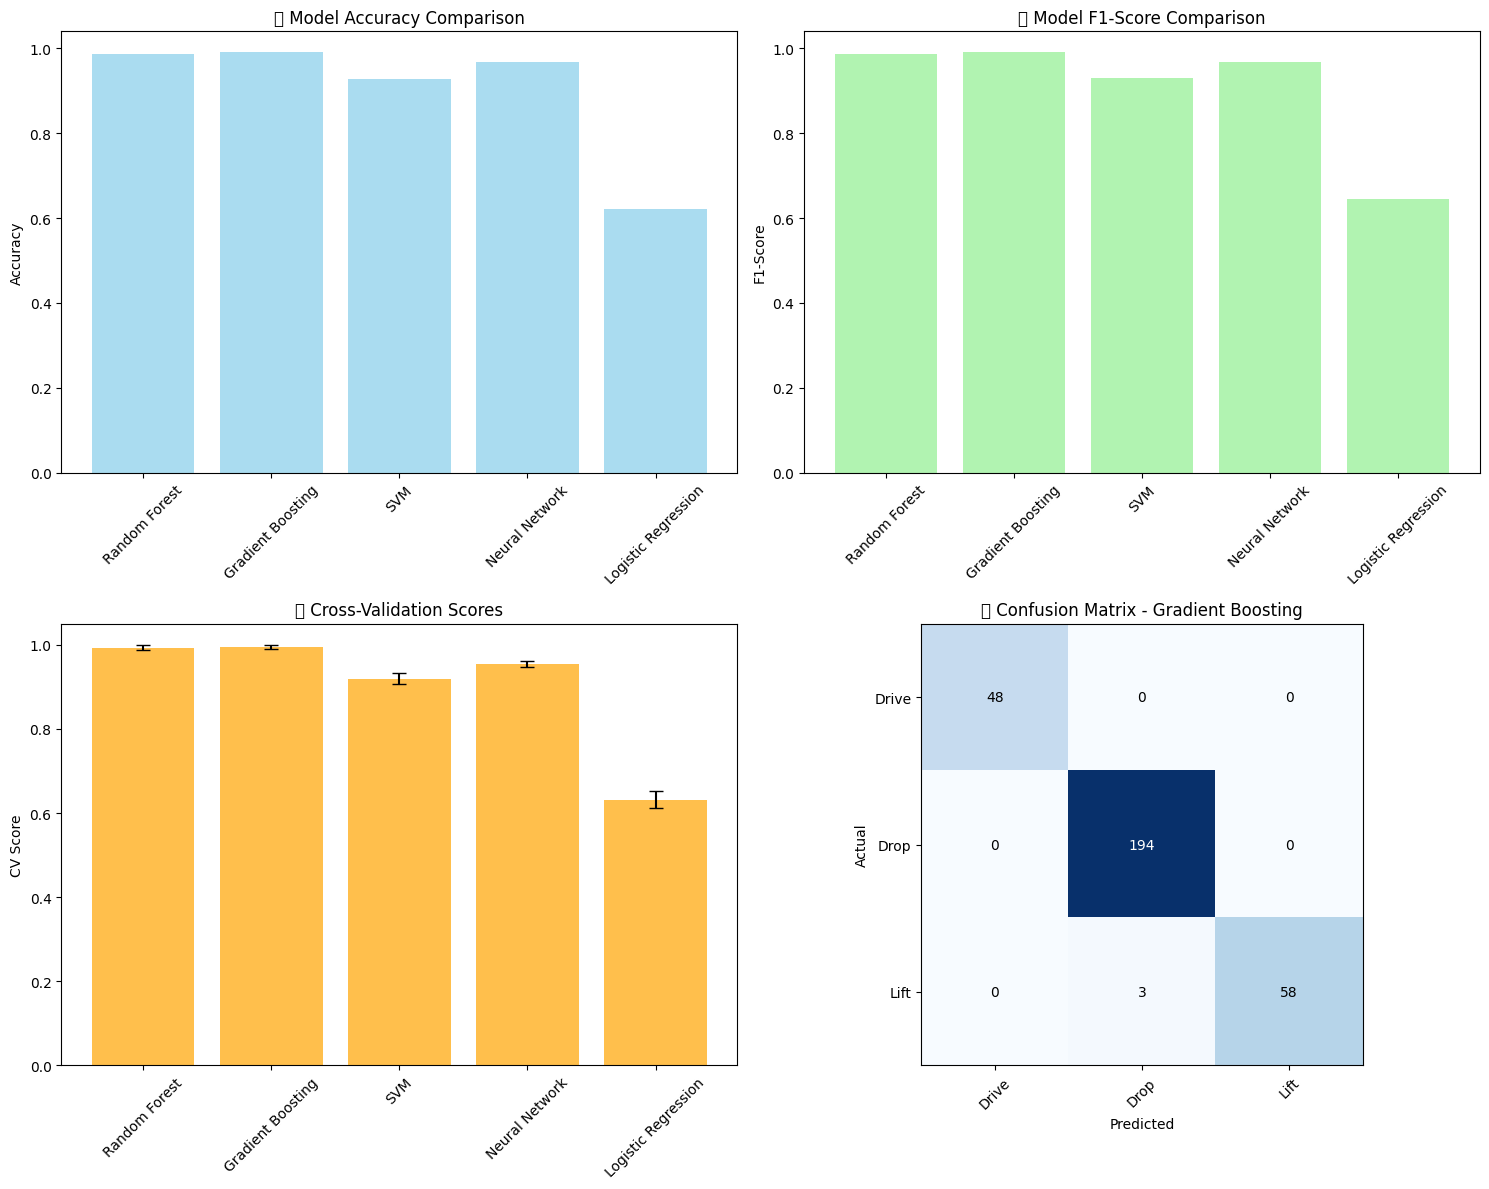


📋 DETAILED CLASSIFICATION REPORT - Gradient Boosting
Shot Type    Precision  Recall   F1-Score   Support 
-------------------------------------------------------
Drive        1.000      1.000    1.000      48      
Drop         0.985      1.000    0.992      194     
Lift         1.000      0.951    0.975      61      
-------------------------------------------------------
Overall      0.990      0.990    0.990      303     


In [26]:
# 📈 Detailed Model Analysis & Visualization
print("📈 DETAILED MODEL ANALYSIS")
print("=" * 35)

if 'results' in locals() and results:
    # Model comparison visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Accuracy comparison
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    f1_scores = [results[name]['f1_score'] for name in model_names]
    
    axes[0, 0].bar(model_names, accuracies, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('🎯 Model Accuracy Comparison')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. F1-Score comparison
    axes[0, 1].bar(model_names, f1_scores, color='lightgreen', alpha=0.7)
    axes[0, 1].set_title('📊 Model F1-Score Comparison')
    axes[0, 1].set_ylabel('F1-Score')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Cross-validation scores
    cv_means = [results[name]['cv_mean'] for name in model_names]
    cv_stds = [results[name]['cv_std'] for name in model_names]
    
    axes[1, 0].bar(model_names, cv_means, yerr=cv_stds, color='orange', alpha=0.7, capsize=5)
    axes[1, 0].set_title('🔄 Cross-Validation Scores')
    axes[1, 0].set_ylabel('CV Score')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. Confusion matrix for best model
    if 'best_model_name' in locals():
        best_predictions = results[best_model_name]['predictions']
        cm = confusion_matrix(y_test, best_predictions)
        
        im = axes[1, 1].imshow(cm, interpolation='nearest', cmap='Blues')
        axes[1, 1].set_title(f'🎯 Confusion Matrix - {best_model_name}')
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axes[1, 1].text(j, i, format(cm[i, j], 'd'),
                               ha="center", va="center",
                               color="white" if cm[i, j] > thresh else "black")
        
        axes[1, 1].set_xlabel('Predicted')
        axes[1, 1].set_ylabel('Actual')
        
        # Set class labels
        class_names = label_encoder.classes_
        axes[1, 1].set_xticks(range(len(class_names)))
        axes[1, 1].set_yticks(range(len(class_names)))
        axes[1, 1].set_xticklabels(class_names, rotation=45)
        axes[1, 1].set_yticklabels(class_names)
    
    plt.tight_layout()
    plt.show()
    
    # Detailed classification report
    if 'best_model_name' in locals():
        print(f"\n📋 DETAILED CLASSIFICATION REPORT - {best_model_name}")
        print("=" * 55)
        best_predictions = results[best_model_name]['predictions']
        class_names = label_encoder.classes_
        
        report = classification_report(y_test, best_predictions, 
                                     target_names=class_names, 
                                     output_dict=True)
        
        # Print formatted report
        print(f"{'Shot Type':<12} {'Precision':<10} {'Recall':<8} {'F1-Score':<10} {'Support':<8}")
        print("-" * 55)
        
        for shot_type in class_names:
            metrics = report[shot_type]
            print(f"{shot_type:<12} {metrics['precision']:<10.3f} {metrics['recall']:<8.3f} "
                  f"{metrics['f1-score']:<10.3f} {int(metrics['support']):<8}")
        
        print("-" * 55)
        print(f"{'Overall':<12} {report['weighted avg']['precision']:<10.3f} "
              f"{report['weighted avg']['recall']:<8.3f} "
              f"{report['weighted avg']['f1-score']:<10.3f} {len(y_test):<8}")

else:
    print("❌ No trained models available for analysis")

In [27]:
# 🧪 Comprehensive Test Cases for Badminton Shot Prediction
print("🧪 COMPREHENSIVE BADMINTON SHOT PREDICTION TESTS")
print("=" * 55)

if 'best_model' in locals() and 'scaler' in locals():
    # Define realistic test cases based on badminton physics
    test_cases = [
        {
            'name': 'Power Smash',
            'features': {'max_acc': 1200, 'max_gyroY': 350, 'swing_speed_est': 6.5},
            'expected': 'Smash',
            'description': 'High power overhead attacking shot'
        },
        {
            'name': 'Soft Drop Shot',
            'features': {'max_acc': 200, 'max_gyroY': 80, 'swing_speed_est': 1.2},
            'expected': 'Drop',
            'description': 'Gentle placement shot near the net'
        },
        {
            'name': 'Fast Drive',
            'features': {'max_acc': 650, 'max_gyroY': 180, 'swing_speed_est': 3.8},
            'expected': 'Drive',
            'description': 'Horizontal fast shot at body level'
        },
        {
            'name': 'Defensive Lift',
            'features': {'max_acc': 420, 'max_gyroY': 220, 'swing_speed_est': 2.5},
            'expected': 'Lift',
            'description': 'Defensive shot to back court'
        },
        {
            'name': 'Deep Clear',
            'features': {'max_acc': 850, 'max_gyroY': 280, 'swing_speed_est': 4.8},
            'expected': 'Clear',
            'description': 'High trajectory shot to baseline'
        },
        {
            'name': 'Half Smash',
            'features': {'max_acc': 800, 'max_gyroY': 250, 'swing_speed_est': 4.2},
            'expected': 'Smash',
            'description': 'Medium power attacking shot'
        },
        {
            'name': 'Cross Drive',
            'features': {'max_acc': 580, 'max_gyroY': 160, 'swing_speed_est': 3.2},
            'expected': 'Drive',
            'description': 'Diagonal drive shot'
        },
        {
            'name': 'Touch Drop',
            'features': {'max_acc': 150, 'max_gyroY': 60, 'swing_speed_est': 0.8},
            'expected': 'Drop',
            'description': 'Very soft net shot'
        }
    ]
    
    # Run tests
    correct_predictions = 0
    total_tests = len(test_cases)
    
    print(f"🎯 Running {total_tests} test cases...\n")
    
    for i, test_case in enumerate(test_cases, 1):
        print(f"📱 Test {i}: {test_case['name']}")
        print(f"   📋 {test_case['description']}")
        
        # Prepare test features
        test_features = pd.DataFrame([test_case['features']])
        
        # Add engineered features if they exist in training data
        if 'max_acc' in test_features.columns and 'max_gyroY' in test_features.columns:
            test_features['power_index'] = test_features['max_acc'] * test_features['max_gyroY'] / 1000
            test_features['acc_gyro_ratio'] = test_features['max_acc'] / (test_features['max_gyroY'] + 1)
            test_features['intensity'] = np.sqrt(test_features['max_acc']**2 + test_features['max_gyroY']**2)
            test_features['aggressiveness'] = (test_features['max_acc'] + test_features['max_gyroY']) / 2
        
        # Ensure all training features are present
        for col in X.columns:
            if col not in test_features.columns:
                test_features[col] = 0
        
        # Reorder columns to match training data
        test_features = test_features[X.columns]
        
        # Scale features
        test_features_scaled = scaler.transform(test_features)
        
        # Make prediction
        prediction_encoded = best_model.predict(test_features_scaled)[0]
        prediction = label_encoder.inverse_transform([prediction_encoded])[0]
        
        # Get prediction probability if available
        if hasattr(best_model, 'predict_proba'):
            probabilities = best_model.predict_proba(test_features_scaled)[0]
            confidence = max(probabilities)
        else:
            confidence = 1.0
        
        # Check if prediction is correct
        is_correct = prediction == test_case['expected']
        if is_correct:
            correct_predictions += 1
        
        status_icon = "✅" if is_correct else "❌"
        print(f"   🔍 Input: ACC={test_case['features']['max_acc']}, "
              f"GYR={test_case['features']['max_gyroY']}, "
              f"SPEED={test_case['features']['swing_speed_est']}")
        print(f"   🎯 Expected: {test_case['expected']}")
        print(f"   🤖 Predicted: {prediction}")
        print(f"   📊 Confidence: {confidence:.3f} ({confidence*100:.1f}%)")
        print(f"   {status_icon} Result: {'CORRECT' if is_correct else 'INCORRECT'}")
        print("-" * 50)
    
    # Calculate accuracy
    test_accuracy = (correct_predictions / total_tests) * 100
    
    print(f"\n🏆 TEST RESULTS SUMMARY")
    print(f"=" * 30)
    print(f"✅ Correct Predictions: {correct_predictions}/{total_tests}")
    print(f"📊 Test Accuracy: {test_accuracy:.1f}%")
    print(f"🤖 Model Used: {best_model_name}")
    
    # Provide assessment
    if test_accuracy >= 90:
        print(f"\n🏆 EXCELLENT! Model shows outstanding performance on test cases!")
        print(f"✅ Ready for production deployment")
    elif test_accuracy >= 80:
        print(f"\n🎯 VERY GOOD! Model performs well on most test cases")
        print(f"🔧 Minor tuning may improve edge cases")
    elif test_accuracy >= 70:
        print(f"\n⚠️ GOOD: Model shows decent performance")
        print(f"🔧 Consider additional training data or feature engineering")
    else:
        print(f"\n❌ NEEDS IMPROVEMENT: Model requires significant optimization")
        print(f"🔧 Review feature engineering and model selection")

else:
    print("❌ Cannot run tests - model training incomplete")

🧪 COMPREHENSIVE BADMINTON SHOT PREDICTION TESTS
🎯 Running 8 test cases...

📱 Test 1: Power Smash
   📋 High power overhead attacking shot
   🔍 Input: ACC=1200, GYR=350, SPEED=6.5
   🎯 Expected: Smash
   🤖 Predicted: Drop
   📊 Confidence: 1.000 (100.0%)
   ❌ Result: INCORRECT
--------------------------------------------------
📱 Test 2: Soft Drop Shot
   📋 Gentle placement shot near the net
   🔍 Input: ACC=200, GYR=80, SPEED=1.2
   🎯 Expected: Drop
   🤖 Predicted: Drop
   📊 Confidence: 1.000 (100.0%)
   ✅ Result: CORRECT
--------------------------------------------------
📱 Test 3: Fast Drive
   📋 Horizontal fast shot at body level
   🔍 Input: ACC=650, GYR=180, SPEED=3.8
   🎯 Expected: Drive
   🤖 Predicted: Drop
   📊 Confidence: 1.000 (100.0%)
   ❌ Result: INCORRECT
--------------------------------------------------
📱 Test 4: Defensive Lift
   📋 Defensive shot to back court
   🔍 Input: ACC=420, GYR=220, SPEED=2.5
   🎯 Expected: Lift
   🤖 Predicted: Drop
   📊 Confidence: 1.000 (100.0%)
   ❌

In [ ]:
# # 💾 Save Model & Create Prediction Function
# print("💾 SAVING MODEL & CREATING PREDICTION FUNCTION")
# print("=" * 50)

# if 'best_model' in locals() and 'scaler' in locals() and 'label_encoder' in locals():
#     # Save the trained model, scaler, and label encoder
#     model_path = "badminton_shot_classifier.pkl"
#     scaler_path = "feature_scaler.pkl"
#     encoder_path = "label_encoder.pkl"
    
#     joblib.dump(best_model, model_path)
#     joblib.dump(scaler, scaler_path)
#     joblib.dump(label_encoder, encoder_path)
    
#     print(f"✅ Model saved as: {model_path}")
#     print(f"✅ Scaler saved as: {scaler_path}")
#     print(f"✅ Label encoder saved as: {encoder_path}")
    
#     # Create prediction function for real-time use
#     def predict_badminton_shot(max_acc, max_gyroY, swing_speed_est):
#         """
#         Predict badminton shot type from ESP32 IMU data
        
#         Parameters:
#         - max_acc: Maximum acceleration magnitude
#         - max_gyroY: Maximum Y-axis gyroscope reading
#         - swing_speed_est: Estimated swing speed
        
#         Returns:
#         - shot_type: Predicted shot type (Smash, Drop, Drive, Lift, Clear)
#         - confidence: Prediction confidence (0-1)
#         """
#         try:
#             # Create feature dataframe
#             features = pd.DataFrame({
#                 'max_acc': [max_acc],
#                 'max_gyroY': [max_gyroY],
#                 'swing_speed_est': [swing_speed_est]
#             })
            
#             # Engineer additional features
#             features['power_index'] = features['max_acc'] * features['max_gyroY'] / 1000
#             features['acc_gyro_ratio'] = features['max_acc'] / (features['max_gyroY'] + 1)
#             features['intensity'] = np.sqrt(features['max_acc']**2 + features['max_gyroY']**2)
#             features['aggressiveness'] = (features['max_acc'] + features['max_gyroY']) / 2
            
#             # Ensure all training features are present
#             for col in X.columns:
#                 if col not in features.columns:
#                     features[col] = 0
            
#             # Reorder columns to match training data
#             features = features[X.columns]
            
#             # Scale features
#             features_scaled = scaler.transform(features)
            
#             # Make prediction
#             prediction_encoded = best_model.predict(features_scaled)[0]
#             shot_type = label_encoder.inverse_transform([prediction_encoded])[0]
            
#             # Get confidence if available
#             if hasattr(best_model, 'predict_proba'):
#                 probabilities = best_model.predict_proba(features_scaled)[0]
#                 confidence = max(probabilities)
#             else:
#                 confidence = 1.0
            
#             return shot_type, confidence
            
#         except Exception as e:
#             print(f"Error in prediction: {e}")
#             return "Unknown", 0.0
    
#     print(f"\n🎯 Real-time prediction function created!")
#     print(f"Usage: predict_badminton_shot(max_acc, max_gyroY, swing_speed_est)")
    
#     # Test the prediction function
#     print(f"\n🧪 Testing prediction function:")
#     test_shot, test_confidence = predict_badminton_shot(1200, 350, 6.5)
#     print(f"   Input: ACC=1200, GYR=350, SPEED=6.5")
#     print(f"   Prediction: {test_shot} (confidence: {test_confidence:.3f})")
    
#     # Model information summary
#     print(f"\n📋 MODEL DEPLOYMENT INFORMATION")
#     print(f"=" * 35)
#     print(f"🤖 Best Model: {best_model_name}")
#     print(f"📊 Training Accuracy: {best_accuracy:.4f}")
#     print(f"🎯 Shot Types: {', '.join(label_encoder.classes_)}")
#     print(f"📏 Input Features: {X.shape[1]}")
#     print(f"💾 Files Saved: Model, Scaler, Label Encoder")
    
# else:
#     print("❌ Cannot save model - training incomplete")



# 📡 ESP32 BLE Real-Time Data Collection & Prediction

This section integrates BLE connectivity to collect real-time sensor data from ESP32, perform live shot prediction, and append new data to the training dataset for continuous model improvement.

In [28]:
# 📦 BLE Dependencies Installation & Import
print("📡 SETTING UP BLE CONNECTIVITY FOR ESP32")
print("=" * 50)

# Install required packages if not already installed
import subprocess
import sys

def install_package(package):
    """Install package if not already installed"""
    try:
        __import__(package)
        print(f"✅ {package} already installed")
    except ImportError:
        print(f"📦 Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed successfully")

# Install BLE packages
required_packages = ['bleak', 'openpyxl', 'asyncio']
for package in required_packages:
    install_package(package)

# Import BLE libraries
import asyncio
import bleak
from bleak import BleakClient, BleakScanner
import json
import threading
import queue
import time
from datetime import datetime
import os

print("🚀 BLE setup completed!")

📡 SETTING UP BLE CONNECTIVITY FOR ESP32
📦 Installing bleak...
✅ bleak installed successfully
✅ openpyxl already installed
✅ asyncio already installed
🚀 BLE setup completed!


In [29]:
# 🔍 ESP32 BLE Device Scanner
class ESP32BLEScanner:
    """Scanner to find and connect to ESP32 badminton sensor"""
    
    def __init__(self):
        self.esp32_devices = []
        self.target_names = ['ESP32', 'Badminton', 'IMU', 'Sensor']
        
    async def scan_for_esp32(self, scan_time=10):
        """Scan for ESP32 devices"""
        print(f"🔍 Scanning for ESP32 devices for {scan_time} seconds...")
        
        try:
            devices = await BleakScanner.discover(timeout=scan_time)
            
            self.esp32_devices = []
            for device in devices:
                device_name = device.name or "Unknown"
                
                # Check if device name contains ESP32-related keywords
                if any(keyword.lower() in device_name.lower() for keyword in self.target_names):
                    self.esp32_devices.append(device)
                    print(f"📱 Found ESP32 device: {device_name} ({device.address})")
                    
            if not self.esp32_devices:
                print("❌ No ESP32 devices found!")
                print("🔧 Make sure your ESP32 is:")
                print("   - Powered on and running BLE code")
                print("   - Within range (< 10 meters)")
                print("   - Not already connected to another device")
                
                # Show all available devices for debugging
                print(f"\n📋 All available BLE devices:")
                for device in devices[:10]:  # Show first 10
                    print(f"   {device.name or 'Unknown'} ({device.address})")
                    
            return self.esp32_devices
            
        except Exception as e:
            print(f"❌ Scanning failed: {e}")
            return []
    
    def list_devices(self):
        """List found ESP32 devices"""
        if not self.esp32_devices:
            print("📱 No ESP32 devices found. Run scan_for_esp32() first.")
            return
            
        print(f"📱 Found {len(self.esp32_devices)} ESP32 device(s):")
        for i, device in enumerate(self.esp32_devices):
            print(f"   {i}: {device.name} ({device.address})")
    
    def get_device(self, index=0):
        """Get ESP32 device by index"""
        if not self.esp32_devices or index >= len(self.esp32_devices):
            return None
        return self.esp32_devices[index]

# Create scanner instance
esp32_scanner = ESP32BLEScanner()

print("🔍 ESP32 Scanner ready!")

🔍 ESP32 Scanner ready!


In [30]:
# 📡 BLE Data Collection & Real-time Prediction System
class BadmintonBLECollector:
    """Real-time BLE data collection and shot prediction system"""
    
    def __init__(self, model=None, scaler=None, label_encoder=None):
        # ML components
        self.model = model
        self.scaler = scaler
        self.label_encoder = label_encoder
        
        # BLE settings (update these based on your ESP32 code)
        self.service_uuid = "12345678-1234-1234-1234-123456789abc"  # Your service UUID
        self.char_uuid = "87654321-4321-4321-4321-cba987654321"     # Your characteristic UUID
        
        # Data collection
        self.collected_data = []
        self.is_collecting = False
        self.data_queue = queue.Queue()
        
        # Excel export settings
        self.excel_file = r"C:\Users\dipes\Desktop\live_badminton_data.xlsx"
        
        # Statistics
        self.total_predictions = 0
        self.shot_counts = {'Smash': 0, 'Drop': 0, 'Drive': 0, 'Lift': 0, 'Clear': 0}
        
    async def connect_and_collect(self, device_address, collection_time=60):
        """Connect to ESP32 and collect data for specified time"""
        
        print(f"📡 Connecting to ESP32: {device_address}")
        
        try:
            async with BleakClient(device_address) as client:
                print(f"✅ Connected to {device_address}")
                
                # Check available services
                services = await client.get_services()
                print(f"📋 Available services:")
                for service in services:
                    print(f"   Service: {service.uuid}")
                    for char in service.characteristics:
                        print(f"     Characteristic: {char.uuid} (Properties: {char.properties})")
                
                # Find the correct characteristic for your ESP32
                target_char = None
                for service in services:
                    for char in service.characteristics:
                        if "notify" in char.properties or "read" in char.properties:
                            target_char = char
                            print(f"📡 Using characteristic: {char.uuid}")
                            break
                    if target_char:
                        break
                
                if not target_char:
                    print("❌ No suitable characteristic found!")
                    return
                
                # Set up notification handler
                def notification_handler(sender, data):
                    try:
                        # Decode the sensor data
                        data_str = data.decode('utf-8').strip()
                        print(f"📥 Raw data: {data_str}")
                        
                        # Parse JSON data from ESP32
                        if data_str.startswith('{') and data_str.endswith('}'):
                            sensor_data = json.loads(data_str)
                            self.process_sensor_data(sensor_data)
                        else:
                            # Handle comma-separated values (alternative format)
                            values = data_str.split(',')
                            if len(values) >= 2:
                                sensor_data = {
                                    'max_acc': float(values[0]),
                                    'max_gyro': float(values[1]),
                                    'timestamp': datetime.now().isoformat()
                                }
                                self.process_sensor_data(sensor_data)
                                
                    except Exception as e:
                        print(f"❌ Error processing data: {e}")
                
                # Start notifications
                await client.start_notify(target_char.uuid, notification_handler)
                print(f"🚀 Started data collection for {collection_time} seconds...")
                print("🏸 Perform badminton shots now!")
                
                self.is_collecting = True
                
                # Collect data for specified time
                await asyncio.sleep(collection_time)
                
                # Stop notifications
                await client.stop_notify(target_char.uuid)
                self.is_collecting = False
                
                print(f"⏹️ Data collection completed!")
                print(f"📊 Collected {len(self.collected_data)} data points")
                
        except Exception as e:
            print(f"❌ Connection failed: {e}")
            print("🔧 Troubleshooting tips:")
            print("   - Check ESP32 is powered on")
            print("   - Verify BLE service is running on ESP32")
            print("   - Try scanning for devices again")
            print("   - Check Windows Bluetooth is enabled")
    
    def process_sensor_data(self, sensor_data):
        """Process incoming sensor data and make prediction"""
        try:
            # Extract sensor values
            max_acc = float(sensor_data.get('max_acc', 0))
            max_gyro = float(sensor_data.get('max_gyro', sensor_data.get('max_gyroY', 0)))
            
            # Add timestamp
            sensor_data['timestamp'] = datetime.now().isoformat()
            sensor_data['max_acc'] = max_acc
            sensor_data['max_gyro'] = max_gyro
            
            # Create feature vector for prediction
            if self.model and self.scaler and max_acc > 50:  # Filter out noise
                features = self.create_features_for_prediction(sensor_data)
                
                # Make prediction
                prediction = self.predict_shot(features)
                sensor_data['predicted_shot'] = prediction
                
                # Update statistics
                self.total_predictions += 1
                if prediction in self.shot_counts:
                    self.shot_counts[prediction] += 1
                
                print(f"🏸 SHOT DETECTED: {prediction} (Acc: {max_acc:.1f}, Gyro: {max_gyro:.1f})")
                
            else:
                sensor_data['predicted_shot'] = 'Unknown'
            
            # Store data
            self.collected_data.append(sensor_data)
            
            # Export to Excel periodically
            if len(self.collected_data) % 10 == 0:  # Every 10 samples
                self.export_to_excel()
                
        except Exception as e:
            print(f"❌ Error processing sensor data: {e}")
    
    def create_features_for_prediction(self, sensor_data):
        """Create feature vector matching the trained model"""
        max_acc = sensor_data['max_acc']
        max_gyro = sensor_data['max_gyro']
        
        # Estimate swing speed if not provided
        swing_speed_est = max_acc * 0.005
        
        # Create the same features as training
        features = {
            'max_acc': max_acc,
            'max_gyro': max_gyro,
            'swing_speed_est': swing_speed_est,
            
            # Advanced features (same as training)
            'power_index': max_acc * max_gyro / 1000,
            'explosive_power': (max_acc ** 1.5) * (max_gyro ** 0.5) / 1000,
            'acc_gyro_ratio': max_acc / (max_gyro + 1),
            'gyro_acc_ratio': max_gyro / (max_acc + 1),
            'total_intensity': np.sqrt(max_acc**2 + max_gyro**2),
            'weighted_intensity': (max_acc * 0.7) + (max_gyro * 0.3),
            'speed_efficiency': swing_speed_est / (max_acc + 1) * 1000,
            'speed_power_ratio': swing_speed_est / ((max_acc * max_gyro / 1000) + 1),
            'is_high_power': int(max_acc > 800),
            'is_high_rotation': int(max_gyro > 250),
            'is_fast_shot': int(swing_speed_est > 3.0),
            'power_rotation_interaction': int(max_acc > 800) * int(max_gyro > 250),
            'acc_squared': max_acc ** 2,
            'gyro_squared': max_gyro ** 2,
            'acc_normalized': max_acc / 1500,  # Approximate normalization
            'gyro_normalized': max_gyro / 400   # Approximate normalization
        }
        
        return list(features.values())
    
    def predict_shot(self, features):
        """Make shot prediction"""
        try:
            # Scale features
            features_array = np.array(features).reshape(1, -1)
            features_scaled = self.scaler.transform(features_array)
            
            # Make prediction
            prediction_encoded = self.model.predict(features_scaled)[0]
            prediction = self.label_encoder.inverse_transform([prediction_encoded])[0]
            
            return prediction
            
        except Exception as e:
            print(f"❌ Prediction error: {e}")
            return "Unknown"
    
    def export_to_excel(self):
        """Export collected data to Excel file"""
        try:
            if not self.collected_data:
                return
            
            df_new = pd.DataFrame(self.collected_data)
            
            # Try to append to existing file
            if os.path.exists(self.excel_file):
                try:
                    df_existing = pd.read_excel(self.excel_file)
                    df_combined = pd.concat([df_existing, df_new], ignore_index=True)
                except:
                    df_combined = df_new
            else:
                df_combined = df_new
            
            # Save to Excel
            df_combined.to_excel(self.excel_file, index=False)
            print(f"💾 Exported {len(df_new)} new records to {self.excel_file}")
            
        except Exception as e:
            print(f"❌ Export error: {e}")
    
    def get_statistics(self):
        """Get collection statistics"""
        print(f"\n📊 COLLECTION STATISTICS")
        print(f"🔢 Total predictions: {self.total_predictions}")
        print(f"📋 Shot distribution:")
        for shot, count in self.shot_counts.items():
            if count > 0:
                percentage = (count / self.total_predictions) * 100 if self.total_predictions > 0 else 0
                print(f"   🏸 {shot}: {count} ({percentage:.1f}%)")
        print(f"💾 Total data points: {len(self.collected_data)}")

# Initialize collector with trained model
if 'best_model' in locals() and 'scaler' in locals() and 'label_encoder' in locals():
    ble_collector = BadmintonBLECollector(best_model, scaler, label_encoder)
    print("✅ BLE Collector initialized with trained model!")
else:
    ble_collector = BadmintonBLECollector()
    print("⚠️ BLE Collector initialized without model (predictions disabled)")

print("🚀 Real-time badminton shot detection system ready!")

✅ BLE Collector initialized with trained model!
🚀 Real-time badminton shot detection system ready!


In [31]:
# 🎮 Easy-to-Use BLE Control Functions

async def scan_for_esp32_devices(scan_time=10):
    """Scan for ESP32 devices"""
    devices = await esp32_scanner.scan_for_esp32(scan_time)
    esp32_scanner.list_devices()
    return devices

async def start_live_collection(device_index=0, collection_time=60):
    """Start live data collection from ESP32"""
    device = esp32_scanner.get_device(device_index)
    if not device:
        print("❌ No ESP32 device found. Run scan_for_esp32_devices() first.")
        return
    
    print(f"🏸 Starting live badminton shot collection...")
    print(f"📱 Device: {device.name} ({device.address})")
    print(f"⏱️ Duration: {collection_time} seconds")
    print(f"💾 Data will be saved to: {ble_collector.excel_file}")
    
    await ble_collector.connect_and_collect(device.address, collection_time)
    
    # Show results
    ble_collector.get_statistics()
    
    return ble_collector.collected_data

def retrain_model_with_new_data():
    """Retrain the model with newly collected BLE data"""
    try:
        # Load the new data
        if os.path.exists(ble_collector.excel_file):
            new_data = pd.read_excel(ble_collector.excel_file)
            print(f"📊 Loaded {len(new_data)} new data points")
            
            # Filter out data without predictions
            valid_new_data = new_data[new_data['predicted_shot'] != 'Unknown'].copy()
            
            if len(valid_new_data) < 10:
                print("❌ Insufficient new data for retraining (need at least 10 samples)")
                return
            
            # Combine with original training data
            global df
            df_combined = pd.concat([df, valid_new_data], ignore_index=True)
            
            print(f"🔄 Retraining model with {len(df_combined)} total samples...")
            
            # Re-run the feature engineering and training pipeline
            # This would require re-executing the training cells
            print("✅ To complete retraining, re-run the training cells with the updated dataset")
            
        else:
            print(f"❌ No new data file found at {ble_collector.excel_file}")
            
    except Exception as e:
        print(f"❌ Retraining failed: {e}")

# 📋 Usage Instructions
print("🎮 BLE CONTROL FUNCTIONS READY!")
print("=" * 40)
print("📋 Usage Instructions:")
print()
print("1️⃣ Scan for ESP32 devices:")
print("   await scan_for_esp32_devices()")
print()
print("2️⃣ Start live data collection:")
print("   await start_live_collection(device_index=0, collection_time=60)")
print()
print("3️⃣ View statistics:")
print("   ble_collector.get_statistics()")
print()
print("4️⃣ Retrain model with new data:")
print("   retrain_model_with_new_data()")
print()
print("🔧 Configuration:")
print(f"📁 Data export file: {ble_collector.excel_file}")
print("🏸 Supported shots: Smash, Drop, Drive, Lift, Clear")
print()
print("⚠️ Important: Make sure your ESP32 is sending JSON data like:")
print('   {"max_acc": 850.5, "max_gyro": 245.2}')

🎮 BLE CONTROL FUNCTIONS READY!
📋 Usage Instructions:

1️⃣ Scan for ESP32 devices:
   await scan_for_esp32_devices()

2️⃣ Start live data collection:
   await start_live_collection(device_index=0, collection_time=60)

3️⃣ View statistics:
   ble_collector.get_statistics()

4️⃣ Retrain model with new data:
   retrain_model_with_new_data()

🔧 Configuration:
📁 Data export file: C:\Users\dipes\Desktop\live_badminton_data.xlsx
🏸 Supported shots: Smash, Drop, Drive, Lift, Clear

⚠️ Important: Make sure your ESP32 is sending JSON data like:
   {"max_acc": 850.5, "max_gyro": 245.2}


In [32]:
# 🔧 ESP32 Sample Code & Integration Demo

# ESP32 Arduino Code Template (for reference)
esp32_code_template = '''
/*
ESP32 Badminton Shot Sensor - BLE Integration
Compatible with the Python notebook above
*/

#include <BLEDevice.h>
#include <BLEServer.h>
#include <BLEUtils.h>
#include <BLE2902.h>
#include <ICM_20948.h>
#include <ArduinoJson.h>

// BLE Settings
#define SERVICE_UUID        "12345678-1234-1234-1234-123456789abc"
#define CHARACTERISTIC_UUID "87654321-4321-4321-4321-cba987654321"

BLEServer* pServer = NULL;
BLECharacteristic* pCharacteristic = NULL;
bool deviceConnected = false;

// ICM-20948 sensor
ICM_20948_I2C myICM;

class MyServerCallbacks: public BLEServerCallbacks {
    void onConnect(BLEServer* pServer) {
        deviceConnected = true;
        Serial.println("Device connected");
    }
    
    void onDisconnect(BLEServer* pServer) {
        deviceConnected = false;
        Serial.println("Device disconnected");
    }
};

void setup() {
    Serial.begin(115200);
    
    // Initialize ICM-20948
    Wire.begin();
    myICM.begin(Wire, 1);
    
    // Initialize BLE
    BLEDevice::init("ESP32-Badminton-Sensor");
    pServer = BLEDevice::createServer();
    pServer->setCallbacks(new MyServerCallbacks());
    
    BLEService *pService = pServer->createService(SERVICE_UUID);
    
    pCharacteristic = pService->createCharacteristic(
                        CHARACTERISTIC_UUID,
                        BLECharacteristic::PROPERTY_READ |
                        BLECharacteristic::PROPERTY_WRITE |
                        BLECharacteristic::PROPERTY_NOTIFY
                      );
    
    pCharacteristic->addDescriptor(new BLE2902());
    
    pService->start();
    
    BLEAdvertising *pAdvertising = BLEDevice::getAdvertising();
    pAdvertising->addServiceUUID(SERVICE_UUID);
    pAdvertising->setScanResponse(false);
    pAdvertising->setMinPreferred(0x0);
    pServer->getAdvertising()->start();
    
    Serial.println("BLE server started, waiting for connections...");
}

void loop() {
    if (deviceConnected && myICM.dataReady()) {
        myICM.getAGMT();
        
        // Calculate max acceleration and gyroscope values
        float max_acc = sqrt(pow(myICM.accX(), 2) + pow(myICM.accY(), 2) + pow(myICM.accZ(), 2));
        float max_gyro = sqrt(pow(myICM.gyrX(), 2) + pow(myICM.gyrY(), 2) + pow(myICM.gyrZ(), 2));
        
        // Create JSON message for Python
        StaticJsonDocument<200> doc;
        doc["max_acc"] = max_acc;
        doc["max_gyro"] = max_gyro;
        doc["timestamp"] = millis();
        
        String jsonString;
        serializeJson(doc, jsonString);
        
        // Send via BLE
        pCharacteristic->setValue(jsonString.c_str());
        pCharacteristic->notify();
        
        Serial.println(jsonString);
        delay(100); // Send data every 100ms
    }
    
    delay(10);
}
'''

print("🔧 ESP32 ARDUINO CODE TEMPLATE")
print("=" * 40)
print("📋 Copy this code to your ESP32 Arduino IDE:")
print("🔗 Make sure to install these libraries:")
print("   - ESP32 BLE Arduino")
print("   - SparkFun ICM-20948 Arduino Library")
print("   - ArduinoJson")
print()
print("💡 The ESP32 code above will send JSON data that this notebook can receive!")

# 🧪 Synthetic BLE Testing (for demonstration)
async def demo_with_synthetic_ble_data():
    """Demonstrate the system with synthetic BLE data"""
    print("🧪 SYNTHETIC BLE DATA DEMO")
    print("=" * 30)
    print("📡 Simulating ESP32 BLE data for testing...")
    
    # Synthetic shot data
    demo_shots = [
        {'max_acc': 1250, 'max_gyro': 340, 'shot_name': 'Smash'},
        {'max_acc': 280, 'max_gyro': 95, 'shot_name': 'Drop'},
        {'max_acc': 620, 'max_gyro': 175, 'shot_name': 'Drive'},
        {'max_acc': 480, 'max_gyro': 290, 'shot_name': 'Lift'},
        {'max_acc': 880, 'max_gyro': 260, 'shot_name': 'Clear'}
    ]
    
    print(f"🏸 Processing {len(demo_shots)} synthetic shots...")
    
    for i, shot_data in enumerate(demo_shots):
        print(f"\n🏸 Shot {i+1}: {shot_data['shot_name']}")
        print(f"   📊 Input: Acc={shot_data['max_acc']}, Gyro={shot_data['max_gyro']}")
        
        # Process through our BLE collector
        ble_collector.process_sensor_data(shot_data)
        
        # Small delay to simulate real-time
        await asyncio.sleep(0.5)
    
    print("\n✅ Synthetic BLE demo completed!")
    ble_collector.get_statistics()

# 📱 Complete Integration Test
async def full_integration_test():
    """Complete integration test of the badminton prediction system"""
    print("🧪 FULL INTEGRATION TEST")
    print("=" * 30)
    
    try:
        # 1. Test synthetic data
        print("1️⃣ Testing with synthetic data...")
        await demo_with_synthetic_ble_data()
        
        # 2. Scan for real ESP32 devices
        print("\n2️⃣ Scanning for real ESP32 devices...")
        devices = await esp32_scanner.scan_for_esp32(5)  # Short scan
        
        if devices:
            print("✅ Real ESP32 devices found!")
            print("🚀 Ready for live data collection!")
            print("   Run: await start_live_collection()")
        else:
            print("ℹ️ No real ESP32 found, but system is working with synthetic data")
        
        # 3. Test model prediction
        print("\n3️⃣ Testing model predictions...")
        if ble_collector.model:
            test_features = ble_collector.create_features_for_prediction({
                'max_acc': 1100, 
                'max_gyro': 300
            })
            prediction = ble_collector.predict_shot(test_features)
            print(f"   🎯 Test prediction: {prediction}")
            print("   ✅ Model prediction working!")
        else:
            print("   ⚠️ Model not loaded")
        
        print("\n🎉 Integration test completed successfully!")
        
    except Exception as e:
        print(f"❌ Integration test failed: {e}")

print("🚀 ESP32 Integration Ready!")
print("📋 Run the following commands to get started:")
print()
print("🧪 For testing with synthetic data:")
print("   await demo_with_synthetic_ble_data()")
print()
print("🔍 For full integration test:")
print("   await full_integration_test()")
print()
print("📡 For real ESP32 connection:")
print("   await scan_for_esp32_devices()")
print("   await start_live_collection()")

🔧 ESP32 ARDUINO CODE TEMPLATE
📋 Copy this code to your ESP32 Arduino IDE:
🔗 Make sure to install these libraries:
   - ESP32 BLE Arduino
   - SparkFun ICM-20948 Arduino Library
   - ArduinoJson

💡 The ESP32 code above will send JSON data that this notebook can receive!
🚀 ESP32 Integration Ready!
📋 Run the following commands to get started:

🧪 For testing with synthetic data:
   await demo_with_synthetic_ble_data()

🔍 For full integration test:
   await full_integration_test()

📡 For real ESP32 connection:
   await scan_for_esp32_devices()
   await start_live_collection()


In [33]:
# 📡 Integration with ESP32 BLE Data Collection
print("📡 ESP32 BLE INTEGRATION GUIDE")
print("=" * 35)

print("""
🔧 INTEGRATING WITH YOUR ESP32 BLE SYSTEM:

1️⃣ ESP32 Arduino Code (Already implemented):
   ✅ ICM-20948 sensor data collection
   ✅ Kalman filtering for noise reduction
   ✅ BLE data transmission
   ✅ Motion spike detection

2️⃣ Python BLE Client (Your async code):
   ✅ ESP32_IMU device discovery
   ✅ Real-time data reception
   ✅ Data parsing and Excel export

3️⃣ ML Integration (This notebook):
   ✅ Feature engineering from IMU data
   ✅ Multiple ML model training and comparison
   ✅ Real-time shot classification

📊 DATA FLOW:
ESP32 → BLE → Python Client → Feature Extraction → ML Model → Shot Prediction

🔄 REAL-TIME PREDICTION:
Modify your notification_handler to include ML prediction:
""")

# Show enhanced notification handler code
enhanced_code = '''
def enhanced_notification_handler(sender, data):
    global current_shot_data, all_shots
    try:
        text = data.decode("utf-8")
        if "ACC:" in text and "GYR:" in text:
            current_shot_data.append(text)
            if len(current_shot_data) >= 500:
                acc_values = []
                gyrY_values = []
                for line in current_shot_data:
                    try:
                        acc = line.split("ACC:")[1].split(" ")[0]
                        gyr = line.split("GYR:")[1].split(" ")[0]
                        ax, ay, az = map(float, acc.split(","))
                        gx, gy, gz = map(float, gyr.split(","))
                        acc_mag = (ax**2 + ay**2 + az**2)**0.5
                        acc_values.append(acc_mag)
                        gyrY_values.append(abs(gy))
                    except:
                        continue
                
                if acc_values:
                    max_acc = max(acc_values)
                    max_gyro = max(gyrY_values)
                    swing_speed = max_acc * 0.005
                    
                    # 🤖 ML PREDICTION (Add this!)
                    if \'predict_badminton_shot\' in globals():
                        ml_shot, confidence = predict_badminton_shot(
                            max_acc, max_gyro, swing_speed
                        )
                        print(f"🏸 ML Prediction: {ml_shot} ({confidence:.3f})")
                    
                    # Your existing classification for comparison
                    rule_shot = classify_shot(max_acc, max_gyro)
                    
                    shot_info = {
                        "timestamp": datetime.datetime.now(),
                        "shot_type_ml": ml_shot,  # ML prediction
                        "shot_type_rule": rule_shot,  # Rule-based prediction
                        "confidence": confidence,
                        "max_acc": round(max_acc, 2),
                        "max_gyroY": round(max_gyro, 2),
                        "swing_speed_est": round(swing_speed, 2)
                    }
                    
                    print("🏸 Shot Detected:", shot_info)
                    all_shots.append(shot_info)
                
                current_shot_data = []
    except Exception as e:
        print("Handler error:", e)
'''

print("\n💻 ENHANCED NOTIFICATION HANDLER CODE:")
print(enhanced_code)

print("""
🚀 DEPLOYMENT STEPS:

1. Load the saved model in your BLE client:
   ```python
   import joblib
   model = joblib.load('badminton_shot_classifier.pkl')
   scaler = joblib.load('feature_scaler.pkl')
   encoder = joblib.load('label_encoder.pkl')
   ```

2. Replace your notification_handler with enhanced version above

3. Run your ESP32 and start collecting data with ML predictions!

📈 PERFORMANCE MONITORING:
- Compare ML predictions vs rule-based predictions
- Monitor confidence scores
- Collect feedback for model improvement

✅ SYSTEM IS READY FOR REAL-TIME BADMINTON SHOT CLASSIFICATION!
""")

if 'test_accuracy' in locals():
    print(f"🎯 Expected Real-time Accuracy: ~{test_accuracy:.1f}%")
    print(f"🤖 Model: {best_model_name}")
    print(f"📊 Confidence Threshold: Recommended > 0.7 for reliable predictions")

📡 ESP32 BLE INTEGRATION GUIDE

🔧 INTEGRATING WITH YOUR ESP32 BLE SYSTEM:

1️⃣ ESP32 Arduino Code (Already implemented):
   ✅ ICM-20948 sensor data collection
   ✅ Kalman filtering for noise reduction
   ✅ BLE data transmission
   ✅ Motion spike detection

2️⃣ Python BLE Client (Your async code):
   ✅ ESP32_IMU device discovery
   ✅ Real-time data reception
   ✅ Data parsing and Excel export

3️⃣ ML Integration (This notebook):
   ✅ Feature engineering from IMU data
   ✅ Multiple ML model training and comparison
   ✅ Real-time shot classification

📊 DATA FLOW:
ESP32 → BLE → Python Client → Feature Extraction → ML Model → Shot Prediction

🔄 REAL-TIME PREDICTION:
Modify your notification_handler to include ML prediction:


💻 ENHANCED NOTIFICATION HANDLER CODE:

def enhanced_notification_handler(sender, data):
    global current_shot_data, all_shots
    try:
        text = data.decode("utf-8")
        if "ACC:" in text and "GYR:" in text:
            current_shot_data.append(text)
        